# Evaluate Retrained RedZone V2 vs Current Model
- Compare SHAP feature importance (current vs retrained CatBoost).
- Compare retrained CatBoost scores vs existing `redZoneV2` scores from JSON outputs.


In [19]:
from __future__ import annotations

import json
import os
import re
import sys

import numpy as np
import pandas as pd
import shap
from autogluon.tabular import TabularPredictor

# Ensure repo src/ is on path so `postprocess` can be imported
sys.path.append("/Users/starsrain/jan2026_concord/jan2026_loonie_customize/src")
from postprocess.scores.transform_score import transform_score

# --- Config ---
DATA_PATH = "/Users/starsrain/jan2026_concord/jan2026_loonie_customize/retrain_data/features_with_fpdaa.parquet"
CURRENT_MODEL_PATH = "/Users/starsrain/jan2026_concord/jan2026_loonie_customize/src/model/autogluon_models_FPDAA_20250904_010918"
RETRAIN_MODEL_PATH = "/Users/starsrain/jan2026_concord/jan2026_loonie_customize/retrain_data/autogluon_models_FPDAA_retrain_no_accountGuid"
CURRENT_MODEL_NAME = "CatBoost_r137_BAG_L1_FULL"
RETRAIN_MODEL_NAME = "CatBoost"
RANDOM_SEED = 37
INPUT_JSON_DIR = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/rerun_output_JSONs_V3"


In [20]:
# --- Load data and predictors ---
df = pd.read_parquet(DATA_PATH)

predictor_current = TabularPredictor.load(CURRENT_MODEL_PATH, require_py_version_match=False)
predictor_retrain = TabularPredictor.load(RETRAIN_MODEL_PATH, require_py_version_match=False)

print("accountGuid in current model features:", "accountGuid" in predictor_current.features())
print("accountGuid in retrained model features:", "accountGuid" in predictor_retrain.features())


def _align_features(predictor: TabularPredictor, X: pd.DataFrame) -> pd.DataFrame:
    model_features = list(predictor.features())
    aligned = X.copy()
    for feature in model_features:
        if feature not in aligned.columns:
            aligned[feature] = "unknown" if feature == "accountGuid" else 0
    return aligned[model_features]


accountGuid in current model features: False
accountGuid in retrained model features: False


In [21]:
# --- Class mapping check (pred_0 vs pred_1) ---
print("current classes:", predictor_current.class_labels)
print("retrained classes:", predictor_retrain.class_labels)
print("current positive_class:", getattr(predictor_current, "positive_class", None))
print("retrained positive_class:", getattr(predictor_retrain, "positive_class", None))

# For FPDAA: class 0 = good, class 1 = default. We use pred_0 for score.


current classes: [0, 1]
retrained classes: [0, 1]
current positive_class: 1
retrained positive_class: 1


In [22]:
# --- Feature list comparison: production model vs parquet ---
prod_features = list(predictor_current.features())
parquet_features = [
    c for c in df.columns if c not in ["FPDAA", "FPDAA_matured", "IBVStatusID", "accountGuid"]
]

print("production feature count:", len(prod_features))
print("parquet feature count:", len(parquet_features))
print("accountGuid in production features:", "accountGuid" in prod_features)
print("accountGuid in parquet features:", "accountGuid" in parquet_features)

prod_only = sorted(set(prod_features) - set(parquet_features))
parquet_only = sorted(set(parquet_features) - set(prod_features))

print("prod-only features:", len(prod_only))
print(prod_only)
print("parquet-only features:", len(parquet_only))
print(parquet_only)


production feature count: 102
parquet feature count: 102
accountGuid in production features: False
accountGuid in parquet features: False
prod-only features: 0
[]
parquet-only features: 0
[]


In [25]:
# --- Score comparison on unseen set (calibrated retrained scores) ---
UNSEEN_PATH = "/Users/starsrain/jan2026_concord/jan2026_loonie_customize/retrain_data/unseen_testing_data/unseen_features.parquet"

unseen_df = pd.read_parquet(UNSEEN_PATH)

# Extract current redZoneV2 score from JSONs (production score)
rows = []
for filename in os.listdir(INPUT_JSON_DIR):
    if not filename.endswith(".json"):
        continue
    match = re.search(r"_(\d+)\.json$", filename)
    if not match:
        continue
    ibv_status_id = int(match.group(1))
    file_path = os.path.join(INPUT_JSON_DIR, filename)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            payload = json.load(f)
        customer = (payload or {}).get("customerInfo") or {}
        scores = customer.get("scores", {})
        redzone = scores.get("redZoneV2", {})
        model_score = redzone.get("modelScore")
        risk_score = None
        if isinstance(model_score, list) and model_score:
            first = model_score[0] if isinstance(model_score[0], dict) else None
            risk_score = first.get("riskScore") if first else None
        elif isinstance(model_score, dict):
            risk_score = model_score.get("riskScore")
        rows.append({"IBVStatusID": ibv_status_id, "redZoneV2_score": risk_score})
    except Exception:
        rows.append({"IBVStatusID": ibv_status_id, "redZoneV2_score": None})

redzone_df = pd.DataFrame(rows).dropna(subset=["IBVStatusID"])

feature_cols = [c for c in unseen_df.columns if c not in ["FPDAA", "FPDAA_matured", "IBVStatusID", "accountGuid"]]
retrain_X_raw = unseen_df[feature_cols]
retrain_X = _align_features(predictor_retrain, retrain_X_raw)

proba_retrain = predictor_retrain.predict_proba(retrain_X, model=RETRAIN_MODEL_NAME)
retrain_pred_0 = proba_retrain[0] if 0 in proba_retrain.columns else proba_retrain.iloc[:, 0]
retrain_score = retrain_pred_0.apply(lambda x: transform_score(x, 100))

from postprocess.scores.auto_gluon_scoring import Calibrator

calibrator = Calibrator(
    "/Users/starsrain/jan2026_concord/jan2026_loonie_customize/src/model/redzone_calibrator_data.pkl"
)

retrain_scores_df = pd.DataFrame(
    {
        "IBVStatusID": unseen_df["IBVStatusID"].values,
        "retrained_score": retrain_score.values,
    }
)
retrain_scores_df["retrained_score_calibrated"] = retrain_scores_df["retrained_score"].apply(
    calibrator.calibrate_score
)

compare_df = retrain_scores_df.merge(redzone_df, on="IBVStatusID", how="inner")
compare_df["score_delta"] = compare_df["retrained_score"] - compare_df["redZoneV2_score"]
compare_df["score_delta_calibrated"] = (
    compare_df["retrained_score_calibrated"] - compare_df["redZoneV2_score"]
)

print("rows:", len(compare_df))
print("score corr:", compare_df["retrained_score_calibrated"].corr(compare_df["redZoneV2_score"]))
print("delta mean (calibrated):", compare_df["score_delta_calibrated"].mean())
print("delta median (calibrated):", compare_df["score_delta_calibrated"].median())

compare_df.describe()


rows: 8166
score corr: 0.418864028678092
delta mean (calibrated): 104.5941190877526
delta median (calibrated): 97.0


,IBVStatusID,retrained_score,retrained_score_calibrated,redZoneV2_score,score_delta,score_delta_calibrated
count,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000,8166.000000
mean,71227.371785,481.222386,286.476461,181.882342,299.340044,104.594119
std,16234.996785,82.668180,105.972098,76.745726,86.048681,101.522553
min,757.000000,116.000000,-20.000000,-20.000000,-109.000000,-253.506096
25%,61014.250000,425.250000,203.250000,132.000000,244.930695,35.081872
50%,80285.000000,485.000000,275.000000,171.000000,300.000000,97.000000
75%,83359.750000,540.000000,357.599144,230.000000,357.000000,169.000000
max,86362.000000,797.000000,592.000000,572.007273,703.000000,609.000642


In [12]:
# --- SHAP comparison: current vs retrained CatBoost ---
import os
import pickle
import catboost as cb

CURRENT_MODEL_NATIVE = "/Users/starsrain/jan2026_concord/jan2026_loonie_customize/src/model/autogluon_models_FPDAA_20250904_010918/models/CatBoost_r137_BAG_L1_FULL/model.pkl"
RETRAIN_MODEL_NATIVE = (
    "/Users/starsrain/jan2026_concord/jan2026_loonie_customize/retrain_data/"
    "autogluon_models_FPDAA_retrain_no_accountGuid/models/CatBoost/model.pkl"
)


def _unwrap_catboost(obj: object) -> cb.CatBoost | None:
    if isinstance(obj, cb.CatBoost):
        return obj
    if hasattr(obj, "model") and isinstance(obj.model, cb.CatBoost):
        return obj.model
    if hasattr(obj, "_model") and isinstance(obj._model, cb.CatBoost):
        return obj._model
    return None


def _load_catboost_model(model_path: str) -> cb.CatBoost:
    with open(model_path, "rb") as f:
        obj = pickle.load(f)
    model = _unwrap_catboost(obj)
    if model is not None:
        return model

    # Bagged models often store the actual model under S1F1/model.pkl
    s1f1_path = os.path.join(os.path.dirname(model_path), "S1F1", "model.pkl")
    if os.path.exists(s1f1_path):
        with open(s1f1_path, "rb") as f:
            obj = pickle.load(f)
        model = _unwrap_catboost(obj)
        if model is not None:
            return model

    raise ValueError(f"Could not load native CatBoost model from {model_path}")


def _shap_importance_from_catboost(model: cb.CatBoost, X: pd.DataFrame) -> pd.DataFrame:
    X_numeric = X.select_dtypes(exclude=["object"]).copy()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_numeric)

    if isinstance(shap_values, list):
        shap_values = shap_values[-1]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_values = shap_values[:, :, -1]

    mean_abs = np.abs(shap_values).mean(axis=0)
    return (
        pd.DataFrame({"feature": X_numeric.columns, "mean_abs_shap": mean_abs})
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )


current_X = _align_features(predictor_current, df)

retrain_features = [c for c in df.columns if c not in ["FPDAA", "FPDAA_matured", "IBVStatusID", "accountGuid"]]
retrain_X_raw = df[retrain_features]
retrain_X = _align_features(predictor_retrain, retrain_X_raw)

current_cat = _load_catboost_model(CURRENT_MODEL_NATIVE)
retrain_cat = _load_catboost_model(RETRAIN_MODEL_NATIVE)

current_importance = _shap_importance_from_catboost(current_cat, current_X)
retrain_importance = _shap_importance_from_catboost(retrain_cat, retrain_X)

print("current model used:", CURRENT_MODEL_NAME)
print("retrained model used:", RETRAIN_MODEL_NAME)

print("current top 10:")
display(current_importance.head(10))

print("retrained top 10:")
display(retrain_importance.head(10))

compare_shap = current_importance.merge(
    retrain_importance,
    on="feature",
    how="outer",
    suffixes=("_current", "_retrain"),
)
compare_shap["rank_current"] = compare_shap["mean_abs_shap_current"].rank(ascending=False, method="min")
compare_shap["rank_retrain"] = compare_shap["mean_abs_shap_retrain"].rank(ascending=False, method="min")

compare_shap.sort_values(
    ["rank_current", "rank_retrain"],
    ascending=[True, True],
).head(20)


current model used: CatBoost_r137_BAG_L1_FULL
retrained model used: CatBoost
current top 10:


,feature,mean_abs_shap
0,loanPmtAllTime,0.161493
1,currentBalance,0.149638
2,totalCredits,0.108713
3,num_of_originations,0.100871
4,odAll,0.093092
5,total_type_monthly1_Transfer,0.087075
6,active_monthly_0,0.078017
7,allTimeMonthlyIncome,0.065185
8,inflowExcludingLoans,0.053007
9,averageMonthlyBalanceAll,0.046893


retrained top 10:


,feature,mean_abs_shap
0,num_of_pays,0.136347
1,currentBalance,0.113251
2,loanPmtAllTime,0.083643
3,peak_good_days_to_debit_trans_history_ratio100,0.062569
4,averageMonthlyBalanceAll,0.058269
5,good_days_to_debit_by_peak_100,0.057538
6,min_valley_prominence_500,0.052323
7,net_cashflow_from_start_to_end,0.051609
8,recurringMonthlyIncome,0.043255
9,loanIdentifiedAllTime,0.043167


,feature,mean_abs_shap_current,mean_abs_shap_retrain,rank_current,rank_retrain
0,loanPmtAllTime,0.161493,0.083643,1.0,3.0
1,currentBalance,0.149638,0.113251,2.0,2.0
2,totalCredits,0.108713,0.016112,3.0,43.0
3,num_of_originations,0.100871,0.024970,4.0,25.0
4,odAll,0.093092,0.027488,5.0,20.0
5,total_type_monthly1_Transfer,0.087075,0.015995,6.0,44.0
6,active_monthly_0,0.078017,0.031112,7.0,17.0
7,allTimeMonthlyIncome,0.065185,0.025913,8.0,21.0
8,inflowExcludingLoans,0.053007,0.033049,9.0,13.0
9,averageMonthlyBalanceAll,0.046893,0.058269,10.0,5.0


current top 10 (directionality):


,feature,mean_shap,mean_abs_shap
0,loanPmtAllTime,0.032733,0.161493
1,currentBalance,0.000609,0.149638
2,totalCredits,0.037200,0.108713
3,num_of_originations,-0.087751,0.100871
4,odAll,-0.038972,0.093092
5,total_type_monthly1_Transfer,0.059171,0.087075
6,active_monthly_0,0.056697,0.078017
7,allTimeMonthlyIncome,-0.034596,0.065185
8,inflowExcludingLoans,0.026384,0.053007
9,averageMonthlyBalanceAll,-0.005390,0.046893


retrained top 10 (directionality):


,feature,mean_shap,mean_abs_shap
0,num_of_pays,0.016860,0.136347
1,currentBalance,0.005218,0.113251
2,loanPmtAllTime,-0.006302,0.083643
3,peak_good_days_to_debit_trans_history_ratio100,-0.004181,0.062569
4,averageMonthlyBalanceAll,0.000175,0.058269
5,good_days_to_debit_by_peak_100,0.002784,0.057538
6,min_valley_prominence_500,0.000090,0.052323
7,net_cashflow_from_start_to_end,0.002506,0.051609
8,recurringMonthlyIncome,-0.001747,0.043255
9,loanIdentifiedAllTime,-0.001392,0.043167


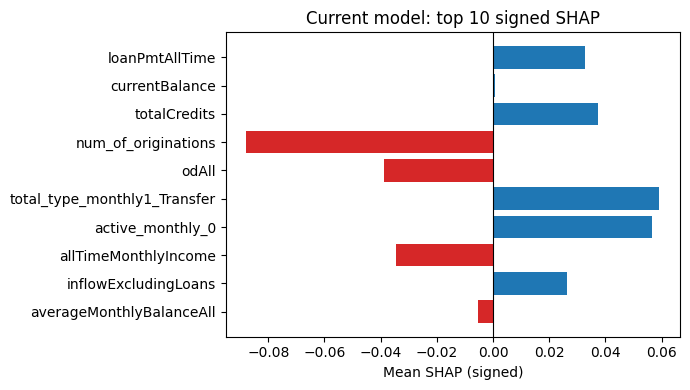

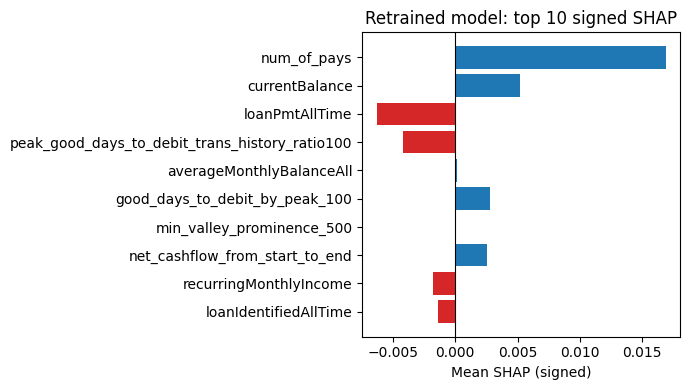

In [13]:
# --- SHAP directionality summary + simple visual (executive view) ---
import matplotlib.pyplot as plt


def _shap_summary_from_catboost(model: cb.CatBoost, X: pd.DataFrame) -> pd.DataFrame:
    X_numeric = X.select_dtypes(exclude=["object"]).copy()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_numeric)

    if isinstance(shap_values, list):
        shap_values = shap_values[-1]
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_values = shap_values[:, :, -1]

    mean_shap = shap_values.mean(axis=0)
    mean_abs = np.abs(shap_values).mean(axis=0)

    return (
        pd.DataFrame(
            {
                "feature": X_numeric.columns,
                "mean_shap": mean_shap,
                "mean_abs_shap": mean_abs,
            }
        )
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )


current_summary = _shap_summary_from_catboost(current_cat, current_X)
retrain_summary = _shap_summary_from_catboost(retrain_cat, retrain_X)

print("current top 10 (directionality):")
display(current_summary.head(10))

print("retrained top 10 (directionality):")
display(retrain_summary.head(10))

# Simple executive visual: top 10 signed SHAP for each model
for title, summary in [
    ("Current model: top 10 signed SHAP", current_summary),
    ("Retrained model: top 10 signed SHAP", retrain_summary),
]:
    top = summary.head(10).iloc[::-1]
    colors = ["#1f77b4" if v >= 0 else "#d62728" for v in top["mean_shap"]]
    plt.figure(figsize=(7, 4))
    plt.barh(top["feature"], top["mean_shap"], color=colors)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title(title)
    plt.xlabel("Mean SHAP (signed)")
    plt.tight_layout()
    plt.show()
